In [1]:
# import libraries
%matplotlib inline
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import datetime

In [2]:
df = pd.read_csv('anomalies.csv', index_col = False)

In [3]:
df[:3]

,Unnamed: 0,negative_spike,positive_spike,user_id,pos_cluster,neg_cluster,kernel_spike,kernel_cluster,normalized_review,time
0,0,"[Timestamp('2010-10-01 04:00:00'), Timestamp('...","[Timestamp('2008-11-01 04:00:00'), Timestamp('...",---1lKK3aKOuomHnwAkAow,"[0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 4, 4, 4]","[0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, ...","[Timestamp('2010-10-01 04:00:00'), Timestamp('...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...",[ 0. 0. 0. 0. ...,"[datetime.datetime(2008, 1, 1, 0, 0), datetime..."
1,1,"[Timestamp('2009-01-01 05:00:00'), Timestamp('...","[Timestamp('2009-07-01 04:00:00'), Timestamp('...",-0IiMAZI2SsQ7VmyzJjokQ,"[0, 0, 0, 0, 1, 2, 2, 2, 3, 4, 4, 4]","[0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, ...","[Timestamp('2009-07-01 04:00:00'), Timestamp('...","[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3]",[ 0. 0. 0. 0. ...,"[datetime.datetime(2009, 1, 1, 0, 0), datetime..."
2,2,"[Timestamp('2010-01-01 05:00:00'), Timestamp('...","[Timestamp('2010-08-01 04:00:00'), Timestamp('...",-2UOdDlzg7XLuUuyOrldhA,"[0, 0, 0, 1, 1, 1, 1, 2]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]","[Timestamp('2010-08-01 04:00:00'), Timestamp('...","[0, 0, 0, 1, 1, 1, 2]",[ 0. 0. 0. 0. ...,"[datetime.datetime(2010, 1, 1, 0, 0), datetime..."


In [4]:
x = filter(lambda x: not len(x) == 0, df.iloc[0]['normalized_review'].split('[')[1].split(']')[0].split(' '))

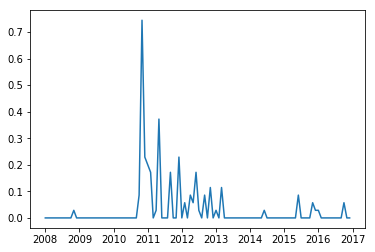

In [5]:
plt.plot(eval(df.iloc[0]['time']), [float(i) for i in x])

In [6]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [7]:
y = filter(lambda x: not len(x) == 0, df.iloc[4]['normalized_review'].split('[')[1].split(']')[0].split(' '))

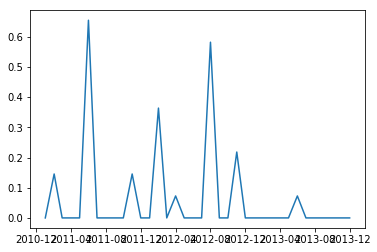

In [8]:
plt.plot(eval(df.iloc[4]['time']), [float(i) for i in y])

In [9]:
z = filter(lambda x: not len(x) == 0, df.iloc[2]['normalized_review'].split('[')[1].split(']')[0].split(' '))

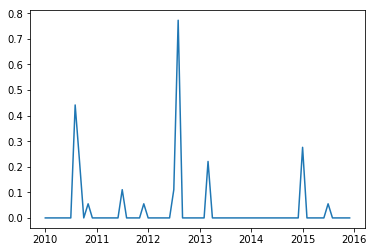

In [10]:
plt.plot(eval(df.iloc[2]['time']), [float(i) for i in z])

In [11]:
x = [float(i) for i in x]

In [12]:
y = [float(i) for i in y]

In [13]:
z = [float(i) for i in z]

In [14]:
DTWDistance(z,y,12)

0.53009407359413963

In [15]:
DTWDistance(x,y,12)

0.59599751751609265

In [16]:
DTWDistance(x,z,12)

0.59028533859345511

In [17]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [18]:
LB_Keogh(x,y,120)

0.08941927999999999

In [19]:
LB_Keogh(y,z,120)

0.0

In [20]:
LB_Keogh(z,x,120)

0.02894773000000006

In [21]:
import random

def k_means_clust(data,num_clust,num_iter,w=12):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,120)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum= clust_sum + data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids

In [22]:
def preprocess(row):
    y = filter(lambda x: not len(x) == 0, row.split('[')[1].split(']')[0].split(' '))
    return [float(i) for i in y]

In [23]:
def getMedian(beg, end, time, review):
    temp = []
    while(beg < len(time) and time[beg] <= end):
        temp.append(review[beg])
        beg+=1
    temp.sort()
    return temp

In [173]:
def step_plot(time, spikes, k_c, review):
    step_plot = []
    current = 0
    while current < len(time):
        # if the current position is the head of spike then append 1 till the cluster ends,
        # move index to the end of spike and 
        # slice the array 
     
        if (not len(spikes) == 0 and time[current] == spikes[0]):
            label = k_c[0]
            index = 0
            
            # get when to end 
            while(not len(k_c) == 0 and index < len(k_c) and label == k_c[index]):
                index += 1
            try:
                end = spikes[index-1]
            except:
                end = spikes[0]
    
            med = getMedian(current, end, time, review)

            i = current
            while(i < len(time) and time[i] <= end):
                step_plot.append(np.mean(med))
#                 step_plot.append(1.0)
                i+=1
            if index == len(k_c):
                spikes = []
                k_c = []
            else:
                spikes = spikes[index:]
                k_c = k_c[index:]

            current = i
      
        # if the current position is not the head of spike then append 0 
        else:
            step_plot.append(0.0)
            current += 1
    return step_plot     

In [183]:
def get_step(user):
    k_c = eval(df.iloc[user]['kernel_cluster'])
    test = df.iloc[user]['kernel_spike'].split('[')[1].split(']')[0].split(', ')
    dates = [i.split('Timestamp')[1].split('(')[1].split(')')[0].split(' ')[0].split('\'')[1] for i in test]
    spikes = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates]
    spikes = [(ti.year, ti.month) for ti in spikes]
    if len(k_c) < len(spikes):
        k_c = []
        for i in range(len(spikes)):
            k_c.append(0)
    t = eval(df.iloc[user]['time'])
    time = [(time.year, time.month) for time in t]
    review = preprocess(df.iloc[user]['normalized_review'])
    x = filter(lambda x: not len(x) == 0, df.iloc[user]['normalized_review'].split('[')[1].split(']')[0].split(' '))
    y = step_plot(time, spikes, k_c, review)
#     plt.plot(t,x, alpha = 0.8)
#     plt.plot(t,y, alpha = 0.4)
    
    return y

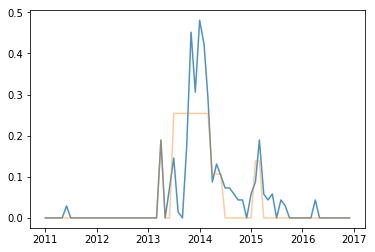

In [26]:
y3 = get_step(661)

In [27]:
DTWDistance(y,y3,60)

0.79185876548516154

In [554]:
DTWDistance(y3,y2,60)

0.45535936420432099

In [184]:
affinity = {}
for i in range(100):
    affinity[i] = {}
    if i%10==0:
            print(i)
    for j in range(i, 100):
        yi = get_step(i)        
        yj = get_step(j)
        affinity[i][j] = DTWDistance(yi,yj,60)        
        if affinity[i][j] == float('inf'):
            affinity[i][j] = DTWDistance(yj,yi,60)

0
10
20
30
40
50
60
70
80
90


In [185]:
mat = []
for i in affinity:
    ith = []
    for j in affinity:
        try:
            ith.append(affinity[i][j])
        except:
            ith.append(affinity[j][i])
    mat.append(ith)

In [71]:
aff = np.matrix(mat)

In [72]:
from sklearn.cluster import DBSCAN
pred = DBSCAN(min_samples=2).fit_predict(aff)

In [186]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
dists = squareform(mat)

In [187]:
Z = hierarchy.linkage(dists)

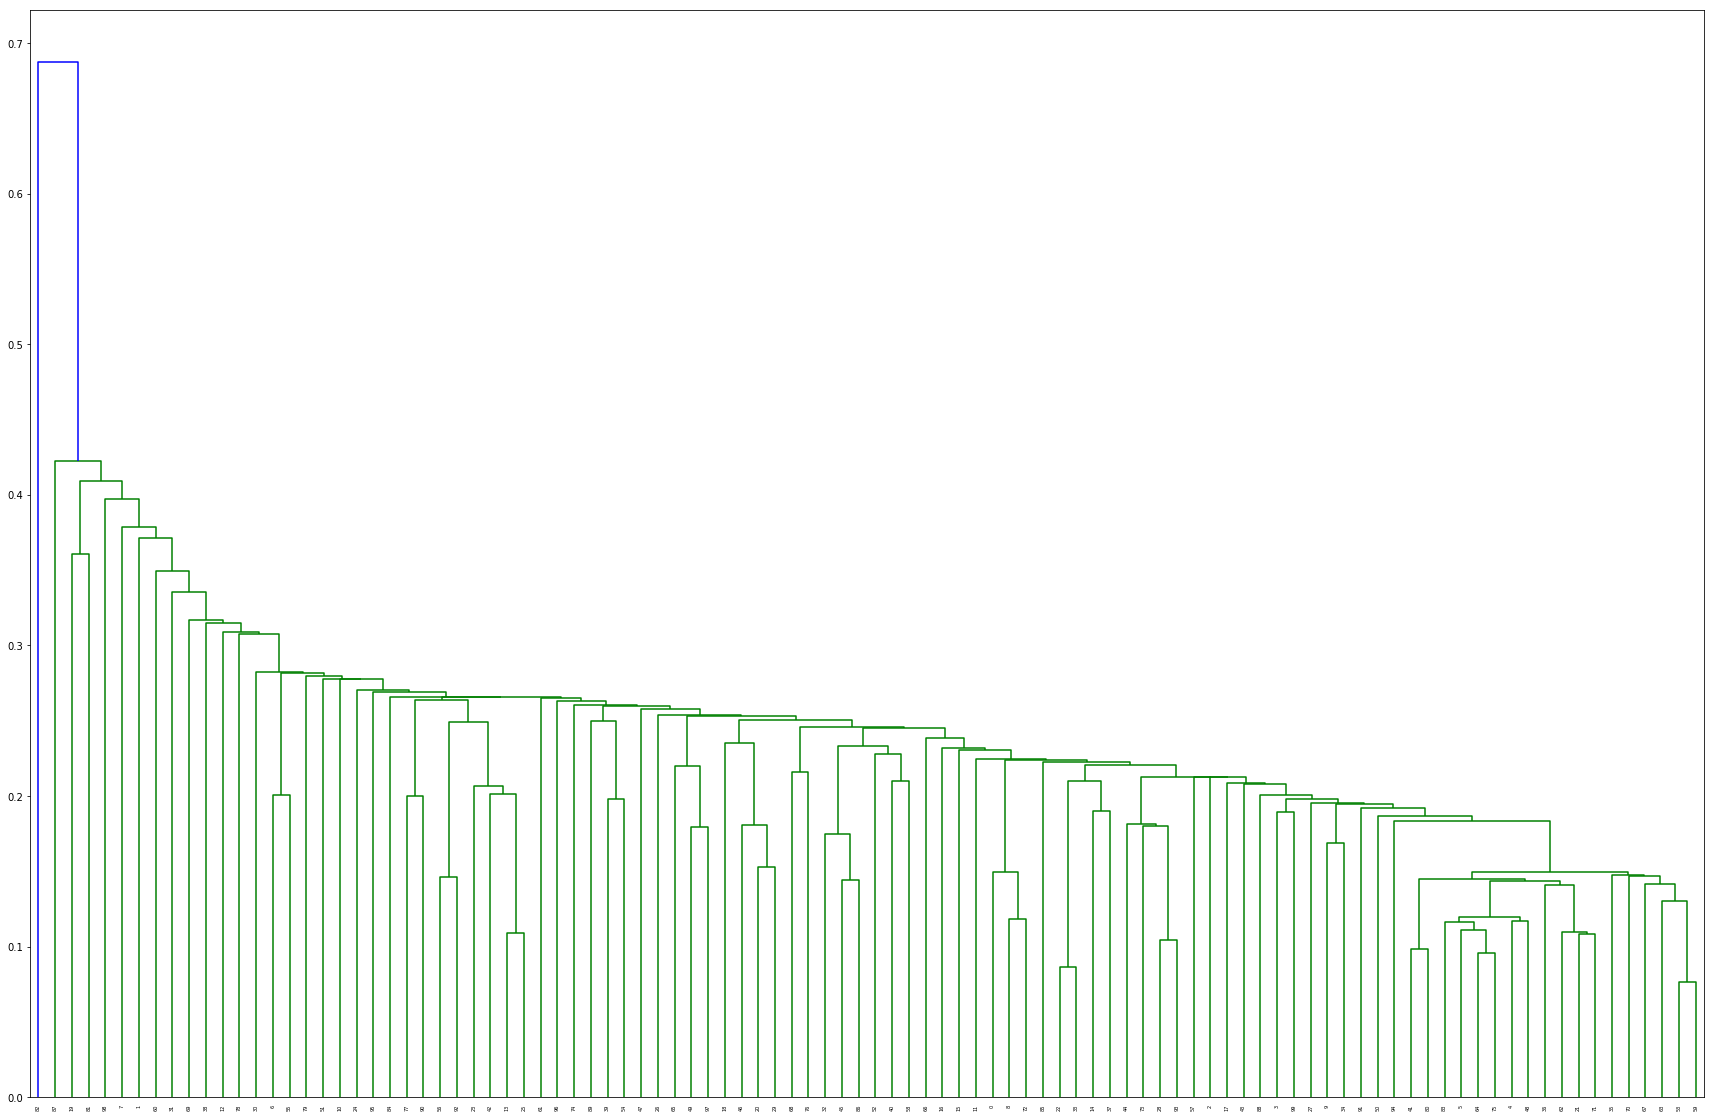

In [188]:
plt.figure(figsize = (30,20))
_ = hierarchy.dendrogram(Z)

In [189]:
from sklearn.cluster import SpectralClustering
cluster = 3
pred = SpectralClustering(cluster).fit_predict(mat2)

In [191]:
cluster_dict = {}
for i in range(cluster):
    cluster_dict[i] = []
for  i,p in enumerate(pred):
    cluster_dict[p].append(i)

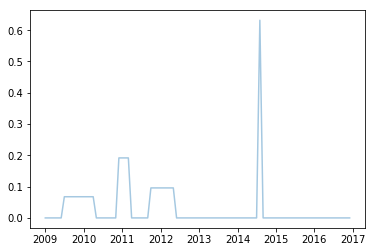

In [145]:
y = get_step(1)

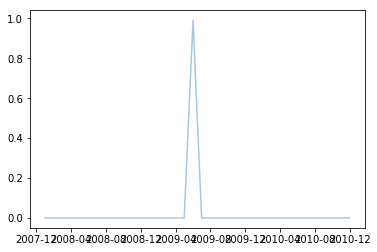

In [146]:
y = get_step(6)

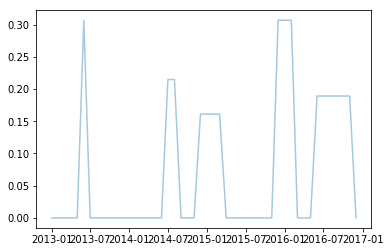

In [147]:
y = get_step(7)

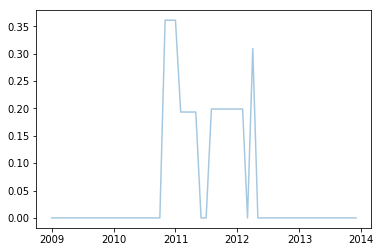

In [148]:
y = get_step(10)

In [152]:
affinity2 = {}
for i in range(100):
    affinity2[i] = {}
    if i%10==0:
            print(i)
    for j in range(i, 100):
        yi = get_step(i)        
        yj = get_step(j)
        affinity2[i][j] = DTWDistance(yi,yj,60)        
        if affinity2[i][j] == float('inf'):
            affinity2[i][j] = DTWDistance(yj,yi,60)

0
10
20
30
40
50
60
70
80
90


In [153]:
mat2 = []
for i in affinity2:
    ith = []
    for j in affinity2:
        try:
            ith.append(affinity2[i][j])
        except:
            ith.append(affinity2[j][i])
    mat2.append(ith)

In [162]:
pred

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [190]:
pred

array([0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0,
       2, 1, 0, 0, 2, 2, 0, 0], dtype=int32)

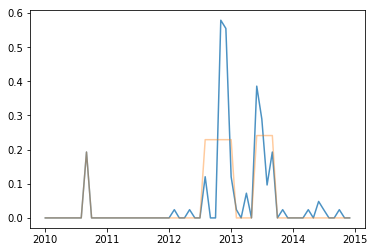

In [179]:
y = get_step(3)

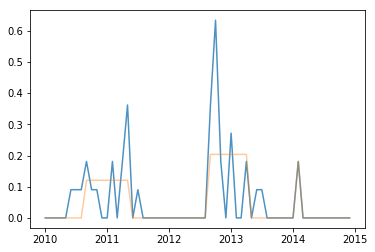

In [180]:
y = get_step(5)

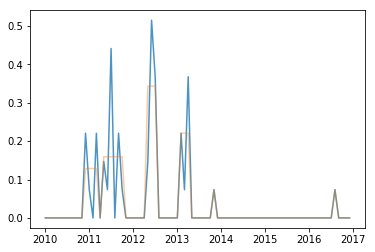

In [181]:
y = get_step(18)

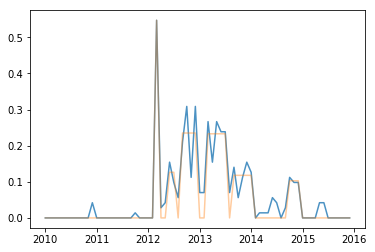

In [182]:
y = get_step(19)

In [192]:
cluster_dict

{0: [0,
  1,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  15,
  16,
  17,
  20,
  21,
  22,
  23,
  26,
  27,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  38,
  39,
  40,
  42,
  43,
  45,
  46,
  47,
  48,
  49,
  50,
  53,
  54,
  58,
  59,
  60,
  61,
  63,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  76,
  77,
  78,
  79,
  80,
  82,
  83,
  85,
  86,
  87,
  88,
  91,
  94,
  95,
  98,
  99],
 1: [4, 13, 14, 24, 25, 28, 41, 51, 55, 65, 89, 90, 93],
 2: [2, 3, 5, 18, 19, 37, 44, 52, 56, 57, 62, 64, 75, 81, 84, 92, 96, 97]}

In [ ]:
y = get_step(4)